# Example Gate Characterization

In [1]:
import os

from qcodes import Station, load_or_create_experiment
from qcodes.dataset.plotting import plot_dataset
from qcodes.dataset.data_set import load_by_run_spec
 
import nanotune as nt
from nanotune.tuningstages.gatecharacterization1d import GateCharacterization1D
from nanotune.classification.classifier import Classifier
from nanotune.tuningstages.settings import DataSettings, SetpointSettings, Classifiers
from nanotune.device.device import Readout, NormalizationConstants

from sim.data_providers import QcodesDataProvider
from sim.qcodes_mocks import MockDoubleQuantumDotInstrument

nt_path = os.path.dirname(os.path.dirname(os.path.abspath(nt.__file__)))

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : /Users/jana/.qcodes/logs/command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : /Users/jana/.qcodes/logs/210729-82876-qcodes.log


Define databases

In [2]:
db_name_original_data = "device_characterization.db"
db_folder_original_data = os.path.join(nt_path, "data", "tuning")
char_db_path = os.path.join(db_folder_original_data, db_name_original_data)
nt.set_database(db_name_original_data, db_folder_original_data)

db_name_replay = 'qdsim_test.db'
db_folder_replay = os.getcwd()

Create qc.Station

In [3]:
station = Station()

qd_mock_instrument = MockDoubleQuantumDotInstrument()
station.add_component(qd_mock_instrument, name="qdmock")

qdsim = qd_mock_instrument.mock_device

 Create the data provider to use for the right plunger pinch-off measurement. 
 Binding the sim.r_plunger pin as the input data provider.

In [5]:
experiment = "GB_Newtown_Dev_3_2"
captured_run_id = 1206

# load original dataset to get device normalization constant
ds = nt.Dataset(1206, db_name_original_data, db_folder_original_data)

pinchoff_right_plunger = QcodesDataProvider(
    [qdsim.right_plunger], 
    char_db_path, 
    "GB_Newtown_Dev_3_2", 
    captured_run_id,
)
qd_mock_instrument.drain.set_data_provider(pinchoff_right_plunger)

Train pinchoff classifier

In [6]:
pinchoff_classifier = Classifier(
    ['pinchoff.npy'],
    'pinchoff',
    data_types=["signal"],
    classifier="SVC",
    folder_path=os.path.join(nt_path, 'data', 'training_data'),
)
pinchoff_classifier.train()

Instantiate nanotune GateCharacterization1D tuning stage

In [7]:
nt.set_database(db_name_replay, db_folder_replay)
exp = load_or_create_experiment("simtest")

In [9]:
gatech = GateCharacterization1D(
    data_settings=DataSettings(
        db_name=db_name_replay,
        db_folder=db_folder_replay,
        normalization_constants=NormalizationConstants(**ds.normalization_constants),
    ),
    setpoint_settings=SetpointSettings(
        voltage_precision=0.01,
        parameters_to_sweep=[qd_mock_instrument.right_plunger],
        safety_voltage_ranges=[(-3, 0)],
        ranges_to_sweep=[(-1, 0)],
    ),
    readout=Readout(transport=qd_mock_instrument.drain),
    classifier=pinchoff_classifier,
    voltage_interval_to_track=0.3,
)

Run gate characterization stage

Starting experimental run with id: 3. 


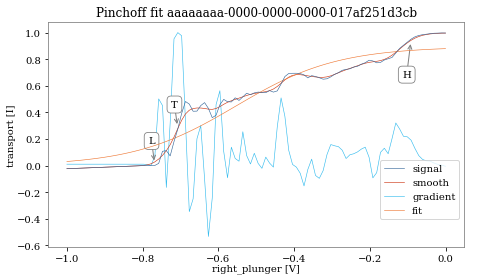

gatecharacterization1d: Good result measured. Regime: pinchoff. Termination reasons: None. 


In [10]:
tuning_result = gatech.run_stage()

In [11]:
tuning_result.success

True

In [12]:
tuning_result.ml_result

{'features': {'transport': {'amplitude': 0.446805496793312,
   'slope': 3.7184570057045274,
   'offset': -1.657143286292184,
   'tanh_sign': 0.9999999999999999,
   'residuals': 0.13731377761110516,
   'low_voltage': -0.767676767676768,
   'low_signal': 0.0017014191789815178,
   'high_voltage': -0.0909090909090909,
   'high_signal': 0.9507964203562004,
   'transition_voltage': -0.707070707070707,
   'transition_signal': 0.2791761004636656,
   'max_signal': 0.9972517232633776,
   'min_signal': -0.023107398869144757}},
 'quality': True,
 'regime': 'pinchoff'}

In [13]:
tuning_result.data_ids

[3]